In [5]:
import DataLoader
import torch, skorch, sklearn, os, json
import numpy as np
import pandas as pd
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet, EEGNetv1, Deep4Net, TCN, EEGNetv4
from skorch.callbacks import LRScheduler
from skorch.dataset import CVSplit
from braindecode import EEGClassifier
from torch.utils.data import TensorDataset
from skorch.helper import predefined_split
from pathlib import Path
from sklearn.utils import class_weight


parameters = {
    # data
    "data_path": "F:/Masterthesis/Data",
    "task": "N170",
    "preprocessing": "medium",
    "n_subjects": 40,
    "reject_incorrect_responses": True,
    # model
    "model": "deep",
    "n_classes": 2,
    "n_chans": 30,
    "input_window_samples": 255,
    "seed": 42,
    # classifier
    "lr": 0.01,
    "weight_decay": 0,
    "batch_size": 64,
    "n_epochs": 25,
    "n_splits": 1,
    "model_folder": "models_test"
}

In [6]:
def init_model(parameters, valid_ds=None, class_weights=None):
    # TODO: Add more models.
    """
    Initializes the model and classifier depending on the parameters.
    """
    # choosing gpu if possible
    cuda = torch.cuda.is_available()
    device = 'cuda' if cuda else 'cpu'
    if cuda:
        torch.backends.cudnn.benchmark = True
    # set seed for reproducability
    set_random_seeds(seed=parameters["seed"], cuda=cuda)
    
    
    # load model
    if parameters["model"] == "eegnet":
        model = EEGNetv4(
            parameters["n_chans"],
            parameters["n_classes"],
            input_window_samples=parameters["input_window_samples"],
            final_conv_length="auto",
        )
    elif parameters["model"] == "shallow":
        model = ShallowFBCSPNet(
            parameters["n_chans"],
            parameters["n_classes"],
            input_window_samples=parameters["input_window_samples"],
            n_filters_time=40, 
            filter_time_length=25, 
            n_filters_spat=40, 
            pool_time_length=75, 
            pool_time_stride=15, 
            final_conv_length="auto"
            
        )
    elif parameters["model"] == "deep":
        model = Deep4Net(
            parameters["n_chans"],
            parameters["n_classes"],
            input_window_samples=parameters["input_window_samples"],
            n_filters_time=25, 
            n_filters_spat=25, 
            filter_time_length=10,
            # TODO: changed stride, need to better figure out why it's needed
            pool_time_length=2, 
            pool_time_stride=2, 
            n_filters_2=50, 
            filter_length_2=10, 
            n_filters_3=100, 
            filter_length_3=10, 
            n_filters_4=200, 
            filter_length_4=10,
            final_conv_length="auto",
        )
    elif parameters["model"] == "tcn":
        model = TCN(
            parameters["n_chans"],
            parameters["n_classes"],
            n_filters=50,
            n_blocks=7,
            kernel_size=2,
            drop_prob=0.3,
            add_log_softmax=True
        )
    
    # send model to gpu
    if cuda:
        model.cuda()
        
    if valid_ds==None:
        train_split=None
    else:
        train_split=predefined_split(valid_ds)
    
    # load classifier
    clf = EEGClassifier(
        model,
        criterion=torch.nn.NLLLoss,
        criterion__weight=class_weights,
        optimizer=torch.optim.AdamW,
        train_split=train_split,
        optimizer__lr=parameters["lr"],
        optimizer__weight_decay=parameters["weight_decay"],
        batch_size=parameters["batch_size"],
        callbacks=[
            #"accuracy",
            #"balanced_accuracy",
            #"roc_auc",
            ("train_balanced_accuracy", skorch.callbacks.EpochScoring(scoring='balanced_accuracy', on_train=True, name="train_balanced_accuracy", lower_is_better=False)),
            ("valid_balanced_accuracy", skorch.callbacks.EpochScoring(scoring='balanced_accuracy', on_train=False, name="valid_balanced_accuracy", lower_is_better=False)),
            ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=parameters["n_epochs"] - 1)),
        ],
        device=device,
    )
    clf.initialize()
    # number of trainable parameters
    #print(sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    return clf

def run_exp(data, labels, parameters):
    """
    Trains classifier using Stratified Cross Validation and saves parameters and history.
    """
    # path to save parameters to
    model_path = os.getcwd()+"\\"+parameters["model_folder"]+"\\"+parameters[
        "model"]+"\\"+parameters["task"]+"\\"+parameters["preprocessing"]+"\\"
    Path(model_path).mkdir(parents=True, exist_ok=True)
    json.dump(parameters, open(model_path+"parameters.json", 'w' ))
    
    # calculate class weights
    class_weights=class_weight.compute_class_weight('balanced',np.unique(labels),labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    class_weights = class_weights.to('cuda')
    
    # push data and labels to gpu
    dataset = TensorDataset(torch.from_numpy(data).to('cuda'),
                            torch.from_numpy(labels).to('cuda'))
    
    # create stratified splits
    cv = sklearn.model_selection.StratifiedShuffleSplit(parameters["n_splits"], test_size=0.2, random_state=42)
    cv_split = cv.split(data,labels)

    # train and validate on each split, then save parameters and history
    i = 0
    for train_idx, test_idx in cv_split:
        i += 1
        #valid_ds = TensorDataset(torch.from_numpy(data[test_idx]), torch.from_numpy(labels[test_idx]))
        clf = init_model(parameters, torch.utils.data.Subset(dataset, test_idx), class_weights)
        clf.fit(torch.utils.data.Subset(dataset, train_idx), y=None, epochs=parameters["n_epochs"])
        clf.save_params(f_params=model_path+"split_"+str(i)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(i)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(i)+"_history.json")
        
def load_exp(parameters):
    """
    Loads the history json and puts it in a dataframe.
    """
    model_path = os.getcwd()+"\\"+parameters["model_folder"]+"\\"+parameters[
        "model"]+"\\"+parameters["task"]+"\\"+parameters["preprocessing"]+"\\"
    df_list = []
    for i in range(1,parameters["n_splits"]+1):
        df_list.append(pd.read_json(model_path+"split_"+str(i)+"_history.json"))
    df = pd.concat(df_list,axis=1)
    
    return df

In [ ]:
def run_exp_per_subject(df, parameters):
    """
    Trains classifier on all but one subject and saves parameters and history.
    """
    # path to save parameters to
    model_path = os.getcwd()+"\\"+parameters["model_folder"]+"\\"+parameters[
        "model"]+"\\"+parameters["task"]+"\\"+parameters["preprocessing"]+"\\"
    Path(model_path).mkdir(parents=True, exist_ok=True)
    json.dump(parameters, open(model_path+"parameters.json", 'w' ))
        
    # train and validate on each subject, then save parameters and history
    for i in range(parameters["n_subjects"]):
        list_train = list(range(parameters["n_subjects"]))
        list_train.remove(i)
        data, labels = DataLoader.create_data_labels(df, list_train)
        # calculate class weights
        class_weights=class_weight.compute_class_weight('balanced',np.unique(labels),labels)
        class_weights=torch.tensor(class_weights,dtype=torch.float)
        class_weights = class_weights.to('cuda')
        # push data and labels to gpu
        dataset = TensorDataset(torch.from_numpy(data).to('cuda'),
                                torch.from_numpy(labels).to('cuda'))
        
        valid_data, valid_labels = DataLoader.create_data_labels(df, [i])
        valid_dataset = TensorDataset(torch.from_numpy(valid_data).to('cuda'),
                                      torch.from_numpy(valid_labels).to('cuda'))
        
        
        clf = init_model(parameters, valid_dataset, class_weights)
        clf.fit(dataset, y=None, epochs=parameters["n_epochs"])
        clf.save_params(f_params=model_path+"split_"+str(i)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(i)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(i)+"_history.json")
 

In [1]:
def run_exp_single_subject(df, parameters):
    """
    Trains classifier on single subject and saves parameters and history.
    """
    # path to save parameters to
    model_path = os.getcwd()+"\\"+parameters["model_folder"]+"\\"+parameters[
        "model"]+"\\"+parameters["task"]+"\\"+parameters["preprocessing"]+"\\"
    Path(model_path).mkdir(parents=True, exist_ok=True)
    json.dump(parameters, open(model_path+"parameters.json", 'w' ))
        
    # train and validate on each subject, then save parameters and history
    for subjectID in range(parameters["n_subjects"]):
        data, labels = DataLoader.create_data_labels(df, [subjectID])
        # calculate class weights
        class_weights=class_weight.compute_class_weight('balanced',np.unique(labels),labels)
        class_weights=torch.tensor(class_weights,dtype=torch.float)
        class_weights = class_weights.to('cuda')
        # push data and labels to gpu
        dataset = TensorDataset(torch.from_numpy(data).to('cuda'),
                                torch.from_numpy(labels).to('cuda'))
        
        
        
        # create stratified splits
        cv = sklearn.model_selection.StratifiedShuffleSplit(parameters["n_splits"], test_size=0.2, random_state=42)
        cv_split = cv.split(data,labels)

        # train and validate on each split, then save parameters and history
        i = 0
        for train_idx, test_idx in cv_split:
            i += 1
            #valid_ds = TensorDataset(torch.from_numpy(data[test_idx]), torch.from_numpy(labels[test_idx]))
            clf = init_model(parameters, torch.utils.data.Subset(dataset, test_idx), class_weights)
            clf.fit(torch.utils.data.Subset(dataset, train_idx), y=None, epochs=parameters["n_epochs"])
            clf.save_params(f_params=model_path+"subject_"+str(subjectID)+"_split_"+str(i)+"_model.pkl",
                           f_optimizer=model_path+"subject_"+str(subjectID)+"_split_"+str(i)+"_optimizer.pkl",
                           f_history=model_path+"subject_"+str(subjectID)+"_split_"+str(i)+"_history.json")

In [8]:
df = DataLoader.load_df(parameters)
data, labels = DataLoader.create_data_labels(df)
run_exp(data, labels, parameters)

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5154        1.1453                     0.5111        0.8097  0.0100  1.7339
      2                     0.5778        0.7673                     0.6270        0.6754  0.0100  0.4926
      3                     0.6350        0.6879                     0.6593        0.6799  0.0098  0.4867
      4                     0.6689        0.6373                     0.6693        0.6131  0.0096  0.4847
      5                     0.6915        0.6103                     0.7271        0.5584  0.0093  0.4818
      6                     0.7092        0.5776                     0.7095        0.6362  0.0090  0.4818
      7                     0.7165        0.5781              

In [17]:
data[:,:,:255].shape

(5781, 30, 255)

In [11]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [5]:
load_exp(parameters)["valid_balanced_accuracy"]

,valid_balanced_accuracy,valid_balanced_accuracy
0,0.825442,0.816657
1,0.829436,0.849560
2,0.843634,0.851829
3,0.836927,0.865340
4,0.839369,0.852928
5,0.838779,0.874365
6,0.856732,0.858774
7,0.851333,0.882238
8,0.854399,0.885209
9,0.857753,0.880289


## Testing

In [18]:
## load history
clf = init_model(parameters)
model_path = os.getcwd()+"\\"+parameters["model_folder"]+"\\"+parameters["model"]+"\\"+parameters["task"]+"\\"+parameters["preprocessing"]+"\\"
clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(1)+"_history.json")

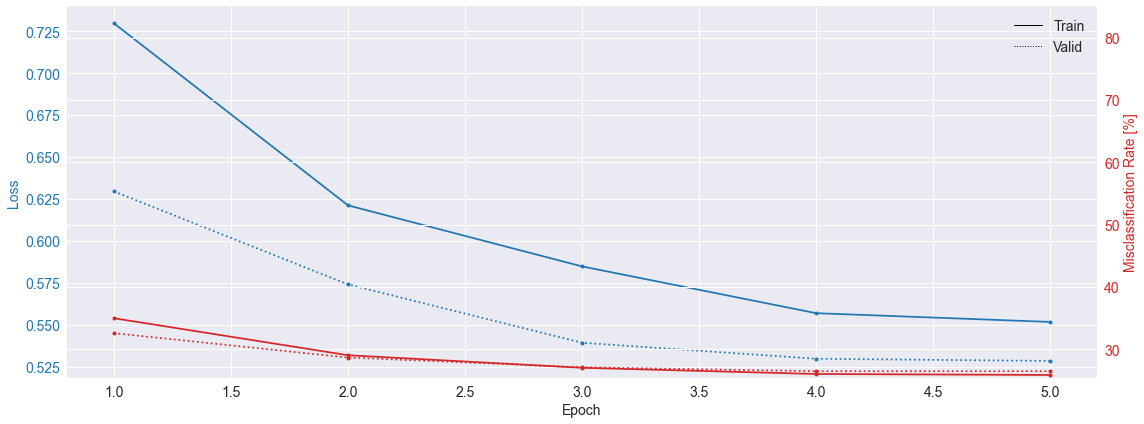

In [19]:
## modified from braindecode
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(16, 6))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14, ms=4)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False, ms=4)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

In [78]:
parameters = {
    # data
    "task": "N2pc",
    "preprocessing": "heavy",
    "n_subjects": 40,
    # model
    "model": "eegnet",
    "n_classes": 2,
    "n_chans": 28,
    "input_window_samples": 257,
    "seed": 42,
    # classifier
    "lr": 0.01,
    "weight_decay": 0,
    "batch_size": 16,
    "n_epochs": 35,
    "n_splits": 5
}

In [79]:
## just as a test, need to fix later
if parameters["preprocessing"]=='light':
    preprocessing = "_shifted_ds_reref_ucbip.set"
elif parameters["preprocessing"]=='medium':
    preprocessing = "_shifted_ds_reref_ucbip_hpfilt.set"
elif parameters["preprocessing"]=='heavy':
    preprocessing = "_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set"
else:
    print("Wrong Preprocessing")

In [80]:
df = DataLoader.load_dataframe(data_path, parameters["task"], preprocessing, parameters["n_subjects"])
data, labels = DataLoader.create_dataset(df)

In [81]:
run_exp(data, labels, parameters)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.5426        0.7117            0.5383        0.6859  0.0100  3.3161
      2            0.6356        0.6722            0.6179        0.6619  0.0100  3.0100
      3            0.6253        0.6555            0.6144        0.6598  0.0099  3.3271
      4            0.6249        0.6519            0.6093        0.6518  0.0098  3.0688
      5            0.6535        0.6475            0.6397        0.6360  0.0097  3.0498
      6            0.6520        0.6393            0.6327        0.6376  0.0095  3.0848
      7            0.6516        0.6371            0.6351        0.6440  0.0093  3.2473
      8            0.6575        0.6366            0.6456        0.6306  0.0090  3.1805
      9            0.6641        0.6339            0.6331        0.6358  0.0087  3.1386
     10            0.6527       

      5            0.6536        0.6441            0.6284        0.6491  0.0097  2.9262
      6            0.6520        0.6441            0.6280        0.6533  0.0095  3.1426
      7            0.6444        0.6376            0.6206        0.6478  0.0093  3.3820
      8            0.6202        0.6356            0.6019        0.6591  0.0090  3.0788
      9            0.6544        0.6354            0.6308        0.6391  0.0087  3.1017
     10            0.6647        0.6324            0.6382        0.6358  0.0084  3.2124
     11            0.6699        0.6315            0.6475        0.6372  0.0080  3.1855
     12            0.6677        0.6258            0.6405        0.6298  0.0076  3.1965
     13            0.6669        0.6271            0.6429        0.6288  0.0072  3.2862
     14            0.6705        0.6266            0.6354        0.6410  0.0068  3.1177
     15            0.6564        0.6220            0.6366        0.6366  0.0064  2.9292
     16            0.6681       

     11            0.6590        0.6289            0.6452        0.6223  0.0080  2.9511
     12            0.6667        0.6302            0.6600        0.6222  0.0076  3.0319
     13            0.6694        0.6255            0.6600        0.6232  0.0072  3.0977
     14            0.6728        0.6269            0.6596        0.6236  0.0068  3.0718
     15            0.6730        0.6213            0.6604        0.6228  0.0064  2.9800
     16            0.6665        0.6232            0.6546        0.6228  0.0059  2.9830
     17            0.6743        0.6200            0.6616        0.6211  0.0055  3.0678
     18            0.6766        0.6183            0.6635        0.6114  0.0050  3.2024
     19            0.6788        0.6142            0.6616        0.6149  0.0045  2.9760
     20            0.6812        0.6153            0.6569        0.6146  0.0041  2.9242
     21            0.6770        0.6136            0.6596        0.6098  0.0036  2.9711
     22            0.6822       

In [90]:
parameters["preprocessing"]="light"
df = load_exp(parameters)
df.loc[34,"valid_accuracy"].mean()

0.6577673692427785

In [91]:
parameters["preprocessing"]="medium"
df = load_exp(parameters)
df.loc[34,"valid_accuracy"].mean()

0.6593286494925837

In [92]:
parameters["preprocessing"]="heavy"
df = load_exp(parameters)
df.loc[34,"valid_accuracy"].mean()

0.6619828259172518

In [9]:
## load model to predict on different split
model_path = os.getcwd()+"\\models\\"+str(parameters["model"])+"\\"+str(
        parameters["task"])+"\\"+str(parameters["preprocessing"])+"\\"
clf = init_model(parameters)
clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(1)+"_history.json")
clf.score(data, labels)

In [ ]:
# Read data from file:
parameters = json.load(open("parameters.json"))